In [1]:
import numpy as np
import tensorflow as tf

2021-12-23 15:13:17.591915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 15:13:17.591933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
n_qubits = 6                  # Number of qubits
num_layers = 5                # Number of layers

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(len(x_train), len(y_test))
print(x_train.shape)

reduce_scale = 5
select_digits = [2, 4, 8]

if select_digits:
  train_index_f = (y_train == -1)
  tests_index_f = (y_test  == -1)
  
  for n_class in select_digits:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)
  x_train = x_train[train_index_f]
  y_train = y_train[train_index_f]

  x_test = x_test[tests_index_f]
  y_test = y_test[tests_index_f]

if reduce_scale:
  x_train = x_train[:int(len(x_train)/reduce_scale)]
  y_train = y_train[:int(len(y_train)/reduce_scale)]

  x_test = x_test[:int(len(x_test)/reduce_scale)]
  y_test = y_test[:int(len(y_test)/reduce_scale)]

60000 10000
(60000, 28, 28)


In [3]:
latent_dim = 2 ** n_qubits    # Selected latent dimensions

class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(name = "faltten_1"),
      tf.keras.layers.Dense(128, activation='relu', name = "dense_1"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_2"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_x"),
      tf.keras.layers.Dense(latent_dim, activation='relu', name = "dense_3"),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu', name = "dense_4"),
      tf.keras.layers.Dense(128, activation='relu', name = "dense_5"),
      tf.keras.layers.Dense(784, activation='sigmoid', name = "dense_6"),
      tf.keras.layers.Reshape((28, 28), name = "reshape_1")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Prepare and compile the model
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mae', metrics=["accuracy"])

# Train the model with the filtered data
autoencoder.fit(x_train, x_train, epochs=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50


2021-12-23 15:13:18.951838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:13:18.952197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 15:13:18.952234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-23 15:13:18.952268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-23 15:13:18.953492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

113/113 [==============================] - 1s 2ms/step - loss: 0.1961 - accuracy: 0.0661 - val_loss: 0.1636 - val_accuracy: 0.0760
Epoch 2/50
113/113 [==============================] - 0s 1ms/step - loss: 0.1437 - accuracy: 0.0865 - val_loss: 0.1294 - val_accuracy: 0.0876
Epoch 3/50
113/113 [==============================] - 0s 1ms/step - loss: 0.1133 - accuracy: 0.1055 - val_loss: 0.1081 - val_accuracy: 0.1077
Epoch 4/50
113/113 [==============================] - 0s 1ms/step - loss: 0.1018 - accuracy: 0.1168 - val_loss: 0.0996 - val_accuracy: 0.1197
Epoch 5/50
113/113 [==============================] - 0s 1ms/step - loss: 0.0966 - accuracy: 0.1199 - val_loss: 0.0945 - val_accuracy: 0.1225
Epoch 6/50
113/113 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.1225 - val_loss: 0.0922 - val_accuracy: 0.1248
Epoch 7/50
113/113 [==============================] - 0s 1ms/step - loss: 0.0907 - accuracy: 0.1268 - val_loss: 0.0915 - val_accuracy: 0.1279
Epoch 8/50
113/11

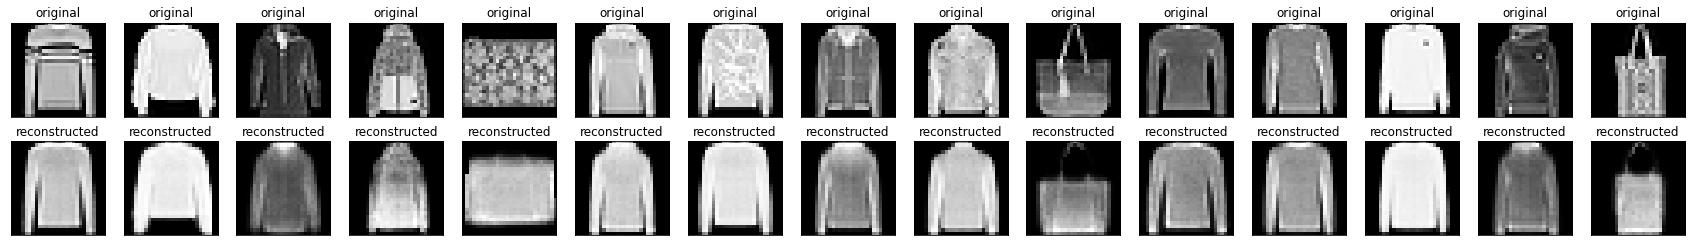

In [4]:
import matplotlib.pyplot as plt

encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 15
plt.figure(figsize=(30, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# Encode data with our new autoencoder
QX_train = autoencoder.encoder(x_train).numpy()
QX_test = autoencoder.encoder(x_test).numpy()

# Change Y values to categorical
QY_train = tf.keras.utils.to_categorical(y_train, 10)
QY_test = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

In [7]:
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev, diff_method='adjoint')
def circuit(weights, inputs=None):
  ''' Quantum QVC Circuit'''

  # Splits need to be done through the tensorflow interface
  weights_each_layer = tf.split(weights, num_or_size_splits=num_layers, axis=0)
  
  # Input normalization
  inputs_1 = inputs / p_np.sqrt(max(p_np.sum(inputs ** 2, axis=-1), 0.001))

  for i, W in enumerate(weights):
#     # Data re-uploading technique
    if i % 2 == 0:
      MottonenStatePreparation(inputs_1.numpy(), wires = range(n_qubits))
    
#     # Neural network layer
    StronglyEntanglingLayers(tf.cast(weights_each_layer[i], tf.float64), wires=range(n_qubits), imprimitive = qml.CY)
  
  # Measurement return
  return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [8]:
weight_shapes = {"weights": (num_layers,n_qubits,3)}

# Model  
input_m = tf.keras.layers.Input(shape=(2 ** n_qubits,), name = "input_0")
keras_1 = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=n_qubits, name = "keras_1")(input_m)
output = tf.keras.layers.Dense(10, activation='softmax', name = "dense_1")(keras_1)

# Model creation
model = tf.keras.Model(inputs=input_m, outputs=output, name="mnist_quantum_model")

# Model compilation
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [9]:
model.summary()

Model: "mnist_quantum_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, 64)]              0         
                                                                 
 keras_1 (KerasLayer)        (None, 6)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 10)                70        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(QX_train, QY_train, batch_size=8, epochs=5, shuffle=True)

Epoch 1/5
450/450 [==============================] - 1060s 2s/step - loss: 0.7991 - categorical_accuracy: 0.7431
Epoch 2/5
450/450 [==============================] - 1056s 2s/step - loss: 0.4178 - categorical_accuracy: 0.8369
Epoch 3/5
450/450 [==============================] - 1051s 2s/step - loss: 0.3689 - categorical_accuracy: 0.8453
Epoch 4/5
450/450 [==============================] - 1048s 2s/step - loss: 0.3507 - categorical_accuracy: 0.8633
Epoch 5/5
450/450 [==============================] - 1066s 2s/step - loss: 0.3385 - categorical_accuracy: 0.8633


In [11]:
results = model.evaluate(QX_test, QY_test)

19/19 [==============================] - 152s 8s/step - loss: 0.3431 - categorical_accuracy: 0.8517


In [13]:
predictions = model.predict(QX_test)

In [16]:
predictions = np.argmax(predictions, axis = 1)

In [24]:
answers_test = np.argmax(QY_test, axis = 1)

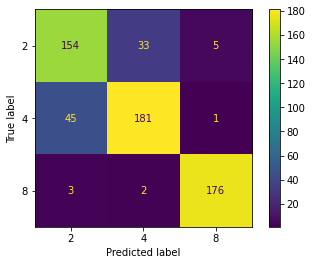

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(predictions, answers_test)